# Imports:

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import urllib.request
import numpy as np
import random
import struct
import torch
import errno
import math
import gzip
import io
import os

# Dataset Class:

In [0]:
class Fashion(Dataset):
	"""Dataset: https://github.com/zalandoresearch/fashion-mnist
	Args:
		root (string): Root directory of dataset where ``processed/training.pt``
			and  ``processed/test.pt`` exist.
		train (bool, optional): If True, creates dataset from ``training.pt``,
			otherwise from ``test.pt``.
		download (bool, optional): If true, downloads the dataset from the internet and
			puts it in root directory. If dataset is already downloaded, it is not
			downloaded again.
		transform (callable, optional): A function/transform that takes in a numpy image
			and may return a horizontally flipped image."""

	urls = 	[
			'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
			'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
			'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
			'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'
			]

	file_name =	[
				'train-images-idx3-ubyte',
				'train-labels-idx1-ubyte',
				't10k-images-idx3-ubyte',
				't10k-labels-idx1-ubyte'
			]

	raw = "raw"
	processsed = "processsed"


	def __init__(self, root, train=True, transform=True, download=False):
		super(Fashion, self).__init__()
		self.root = root
		self.transform = transform
		self.train = train
		self.tensor_transform = transforms.ToTensor()

		raw_path = os.path.join(self.root,self.raw)
		if download and (os.path.exists(raw_path) == False):
			self.download(self.root)

		if self.train:
			train_path = os.path.join(self.root,self.processsed,"training_set.pt")
			self.train_images, self.train_labels = torch.load(train_path)
		else:
			test_path = os.path.join(self.root,self.processsed,"testing_set.pt")
			self.test_images, self.test_labels = torch.load(test_path)



	'''
	__getitem__(index) -> Will return the image and label at the specified index
	
	If transform parametr of class is set as True the function would or would not
	perform a random horizontal flip of the image.
	'''
	def __getitem__(self,index):
		if self.train:
			image, label = self.train_images[index], self.train_labels[index]
		else:
			image, label = self.test_images[index], self.test_labels[index]

		image = image.numpy()
		image = np.rot90(image,axes = (1,2)).copy()

		if self.transform and self.train:
			image = self.transform_process(image)

		image = self.tensor_transform(image)
		image = image.contiguous()
		image = image.view(1,28,28)
			
		return image,label


	def __len__(self):
		if self.train:
			return(len(self.train_images))
		else:
			return(len(self.test_images))


	def transform_process(self, image): #Would or would not return a flipped image
		self.rotate = random.getrandbits(1)
		image = np.flip(image,self.rotate).copy()
		return image

	'''
	download(root) -> The function will download and save the MNIST images in raw
	format under the 'raw' folder under the user specified root directory
	'''

	def download(self, root):
		raw_path = os.path.join(self.root,self.raw)
		processsed_path = os.path.join(self.root,self.processsed)

		try:
			os.makedirs(raw_path)
			os.makedirs(processsed_path)
		except OSError as exc:
			if exc.errno != errno.EEXIST:
				raise
			pass

		for file_index in range(len(self.file_name)):
			print("Downloading:",self.urls[file_index])
			urllib.request.urlretrieve(self.urls[file_index],(self.file_name[file_index]+'.gz'))
			print("Extracting:",self.file_name[file_index]+".gz")
			f = gzip.open(self.file_name[file_index]+'.gz', 'rb')
			with open(raw_path+"/"+self.file_name[file_index],'wb') as w:
				for line in f.readlines():
					w.write(line)	
			f.close()
			os.remove(self.file_name[file_index]+".gz")

		print()
		print("Raw data downloaded and extracted in your specified root directory under /raw")
		print()
		self.process(self.root)

	'''
	process(root) -> Will process the raw downloaded files into a usable format
	and store them into the a 'processed' folder under user specified root
	directory.
	'''

	def process(self, root):
		raw_path = os.path.join(self.root,self.raw)
		processsed_path = os.path.join(self.root,self.processsed)

		print("Processing training data")
		train_image = self.readimg(self.root, self.file_name[0], 2051)
		train_label	= self.readlab(self.root, self.file_name[1], 2049)
		train_data = (train_image,train_label)

		print("Processing testing data")
		test_image = self.readimg(self.root, self.file_name[2], 2051)
		test_label = self.readlab(self.root, self.file_name[3], 2049)
		test_data = (test_image,test_label)

		train_path = os.path.join(self.root,self.processsed,"training_set.pt")
		with open(train_path,"wb") as f:
			torch.save(train_data,f)

		test_path = os.path.join(self.root,self.processsed,"testing_set.pt")
		with open(test_path,"wb") as f:
			torch.save(test_data,f)
		print()
		print("Processed data has been stored in your specified root directory under /processsed")
		print()


	def readimg(self, root, file, magic):
		image = []
		path = os.path.join(self.root,self.raw,file)
		with open(path,'rb') as f:
			magic_number, size, row, col = struct.unpack('>IIII',f.read(16))
			assert (magic_number == magic)
			for run in range(size*row*col):
				image.append(list(struct.unpack('B',f.read(1)))[0])
			image = np.asarray(image, dtype = np.float32)
			return (torch.from_numpy(image).view(size,1,row,col))


	def readlab(self, root, file, magic):
		label = []
		path = os.path.join(self.root,self.raw,file)
		with open(path,'rb') as f:
			magic_number, size = struct.unpack(">II",f.read(8))
			assert (magic_number == magic)
			for run in range(size):
				label.append(list(struct.unpack('b',f.read(1)))[0])
			label = np.asarray(label)
			return (torch.from_numpy(label))

# Initialising Dataset Class

In [3]:
train_dataset = Fashion(root = "./FashionMNIS", train = True, transform = True, download = True)
test_dataset = Fashion(root = "./FashionMNIS", train = False, transform = False, download = True)

Downloading: http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Extracting: train-images-idx3-ubyte.gz
Downloading: http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Extracting: train-labels-idx1-ubyte.gz
Downloading: http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
Extracting: t10k-images-idx3-ubyte.gz
Downloading: http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
Extracting: t10k-labels-idx1-ubyte.gz

Raw data downloaded and extracted in your specified root directory under /raw

Processing training data
Processing testing data

Processed data has been stored in your specified root directory under /processsed



# Defining Batch Size and Total Iterations

In [0]:
'''
Calculation of total epochs using a defined batch size(batch_size)
and total iterations(n_ters)
'''

batch_size = 100
n_iters = 18000
epoch_size = n_iters/(len(train_dataset)/batch_size)

# Making the Test Dataset Iterable

In [0]:

'''
Loading the test dataset (test_loader)
'''

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

#MNIST Image Examples:

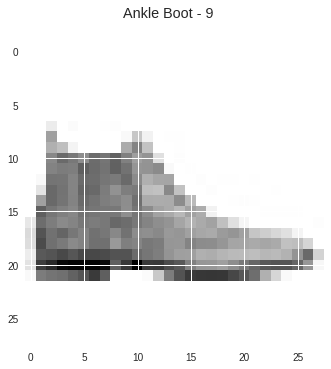

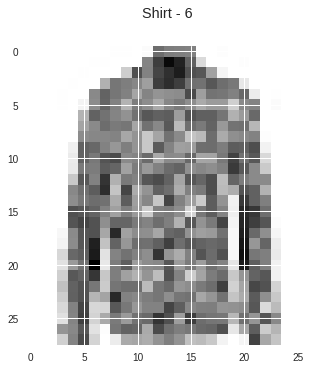

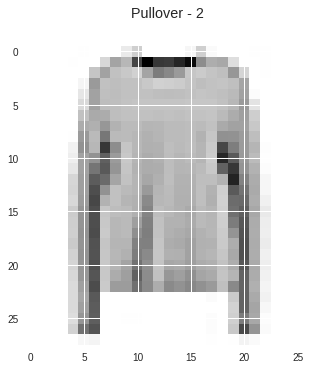

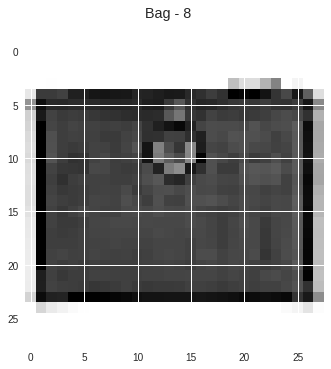

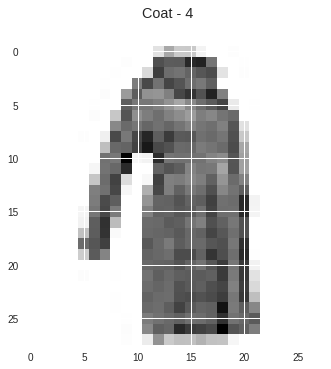

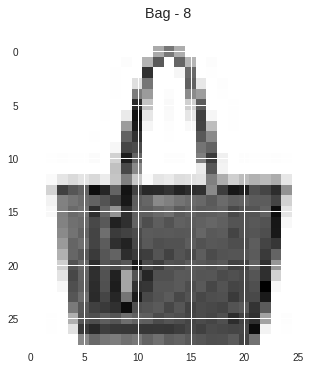

In [6]:
image_dict = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress',
			  4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
			  8:'Bag', 9:'Ankle Boot'}
for index, (images,labels) in enumerate(test_loader):
	image=images[index][0]
	label = labels[index]
	plt.imshow(image)
	plt.suptitle(image_dict[label]+" - "+str(label))
	plt.show()
	if index == 5:
		break

# Neurel Network Model

In [0]:
'''
Model Details:

Two Convolutional Layers:
      - Using ReLU activation
      - Batch Normalisation
      - Uniform Xavier Weigths
      - Max Pooling
      
One Fully Connected Layer:
      - Using ReLU activation
      
One Fully Connected Layer:
      - Output Layer

'''


class CNNModel(nn.Module):
	def __init__(self):
		super (CNNModel, self).__init__()

		self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
		self.relu1 = nn.ReLU()
		self.norm1 = nn.BatchNorm2d(32)
		nn.init.xavier_uniform(self.cnn1.weight)

		self.maxpool1 = nn.MaxPool2d(kernel_size=2)

		self.cnn2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 2)
		self.relu2 = nn.ReLU()
		self.norm2 = nn.BatchNorm2d(64)
		nn.init.xavier_uniform(self.cnn2.weight)

		self.maxpool2 = nn.MaxPool2d(kernel_size=2)

		self.fc1 = nn.Linear(4096, 4096)
		self.fcrelu = nn.ReLU()

		self.fc2 = nn.Linear(4096, 10)

	def forward(self, x):
		out = self.cnn1(x)
		out = self.relu1(out)
		out = self.norm1(out)

		out = self.maxpool1(out)

		out = self.cnn2(out)
		out = self.relu2(out)
		out = self.norm2(out)

		out = self.maxpool2(out)

		out = out.view(out.size(0),-1)

		out = self.fc1(out)
		out = self.fcrelu(out)

		out = self.fc2(out)
		return out

# Instantiate Model Class

In [0]:
'''
Instantiating the model class
'''

model = CNNModel()
if torch.cuda.is_available():
	model.cuda()

# Instantiate Loss and Optimizer Class

In [0]:


'''
Loss Function: Cross Entropy Loss
Optimizer: Stochastic Gradient Descent (Nesterov Momentum is enabled).

Variable: learning_rate -> Stores the learning rate for the optimizer function.
          moment -> Stores the momentum for the optimizer function.
'''

criterion = nn.CrossEntropyLoss()

learning_rate = 0.015
moment = 0.9
optimizer = optim.SGD(model.parameters(),lr = learning_rate, momentum = moment, nesterov = True)

# Training the Model
Loading the training dataset after every epoch which will load it from the Fashion Dataset Class making a new train loader for every new epoch causing random flips and random shuffling of above exampled Fashion MNIST images. 

In [10]:
iter = 0
for epoch in range(int(math.ceil(epoch_size))):

	'''
	Loading the training dataset after every epoch which will
	load it from the Fashion Dataset Class making a new train
	loader for every new epoch causing random flips and random
	shuffling of above exampled Fashion MNIST images. 
	'''

	train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
	for i, (images, labels) in enumerate(train_loader):
		if torch.cuda.is_available():
			images = Variable(images.cuda())
			labels = Variable(labels.cuda())
		else:
			images = Variable(images)
			labels = Variable(labels)
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs,labels)
		loss.backward()
		optimizer.step()
		iter += 1

		'''
		At every 3000th epoch a test on the above initialised test dataset
		(test_loader) would be performed and an accuracy would be provided.
		'''

		if iter%3000 == 0:
			correct = 0
			total = 0
			for image,label in test_loader:
				if torch.cuda.is_available():
					image = Variable(image.cuda())
				else:
					image = Variable(image)
				output = model(image)
				_, predicted = torch.max(output.data,1)
				total += label.size(0)
				if torch.cuda.is_available():
					correct += (predicted.cpu() == label.cpu()).sum()
				else:
					correct += (predicted == label).sum()

			accuracy = 100 * (correct/total)
			print('Iteration: {} Loss: {} Accuracy: {}'.format(iter, round(loss.data[0],5), round(accuracy,2)))

Iteration: 3000 Loss: 0.09267 Accuracy: 91.71
Iteration: 6000 Loss: 0.17845 Accuracy: 92.2
Iteration: 9000 Loss: 0.04771 Accuracy: 92.66
Iteration: 12000 Loss: 0.00568 Accuracy: 93.12
Iteration: 15000 Loss: 0.00323 Accuracy: 93.29
Iteration: 18000 Loss: 0.00092 Accuracy: 93.42
